# Import necessary depencencies

In [1]:
import numpy as np
from keras.layers import Dropout, Activation, Dense
from keras.models import Sequential
from keras.optimizers import TFOptimizer
import model_evaluation_utils as meu
import utils
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM
import xgboost as xgb
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, validation_curve
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
import pandas as pd
from keras.regularizers import l2
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
#from scipy.misc import comb
from scipy.special import comb
import math
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import sklearn
import utils
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import cross_val_score
else:
    from sklearn.model_selection import cross_val_score

import tensorflow as tf

np.set_printoptions(precision=2, linewidth=80)
NWORKERS=16

Using TensorFlow backend.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rkaushik/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Load normalized data

In [2]:
# train and test datasets
train_reviews = utils.readFromDisk('train_reviews')
train_sentiments = utils.readFromDisk('train_sentiments')
test_reviews = utils.readFromDisk('test_reviews')
test_sentiments = utils.readFromDisk('test_sentiments')
tokenized_train = utils.readFromDisk('tokenized_train')
tokenized_test = utils.readFromDisk('tokenized_test')
train_sentiments_encoded = utils.readFromDisk('train_sentiments_encoded')
test_sentiments_encoded = utils.readFromDisk('test_sentiments_encoded')


train_features = utils.readFromDisk('train_glove_features')
test_features = utils.readFromDisk('test_glove_features')

#labelencoder used for encoding in feature engg
le = utils.readFromDisk('label_encoder')



# -------------------------------------------------------------------------
# Logistic Regression (hyperparameter tuning and caching)


In [ ]:
#validation curves
param_name = 'C'
param_range=np.linspace(1, 15, 4,dtype=int)
classifier=LogisticRegression()
title=param_name

meu.validationCurve(classifier,train_features,train_sentiments,param_name,param_range,NWORKERS,title)


In [ ]:
try:
    lr=utils.readFromDisk('lr')
except FileNotFoundError as te:
    lr0 = LogisticRegression()
    lr_hyperparameters = {    
        'C' : [1],
        #'penalty' : ['l2'],
        'max_iter':[1000]
    }
    lr_clf = RandomizedSearchCV(lr0, lr_hyperparameters,cv=5, n_iter=10,n_jobs=-1)

    # Fit grid search
    lr = lr_clf.fit(train_features,train_sentiments)

    utils.writeToDisk(lr,'lr')

In [ ]:
    # View best hyperparameters
    lr.best_estimator_.get_params()

In [ ]:
# Predict target vector
lr_predictions=lr.predict(test_features)


## Logistic Regression - Performance

In [ ]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_predictions,
                                      classes=[1,0])


## Logistic Regression - Learning Curve

In [ ]:
meu.learningCurve(train_features,train_sentiments,lr.best_estimator_,5,np.linspace(.1, 0.7, 7))


# SVM using sgd classifier (hyperparameter tuning and caching)


In [ ]:
#validation curves
param_name = 'alpha'
param_range=[0.00001,0.0001, 0.001, 0.01, 0.1]
classifier=SGDClassifier()
title=param_name

meu.validationCurve(classifier,train_features,train_sentiments,param_name,param_range,NWORKERS,title)

In [ ]:
try:
    svm=utils.readFromDisk('svm')
except FileNotFoundError as te:
    #svm0 = SGDClassifier(max_iter=500,n_jobs=NWORKERS)
    svm0 = SGDClassifier()

    svm_n_jobs=[NWORKERS]
    svm_max_iter=[1000]
    svm_loss= ["hinge"]
    svm_alpha = [0.00001]
    svm_penalty = ["l2"]
    svm_hyperparameters = dict(max_iter=[1000],loss=svm_loss, alpha=svm_alpha,penalty=svm_penalty,n_jobs=svm_n_jobs)

    svm_clf = GridSearchCV(svm0, svm_hyperparameters,cv=5, n_jobs=1)

    svm = svm_clf.fit(train_features,train_sentiments)

    utils.writeToDisk(svm,'svm')


In [ ]:
    svm.best_estimator_.get_params()

In [ ]:
svm_predictions=svm.predict(test_features)

## SVM - Performance

In [ ]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_predictions,
                                      classes=[1,0])


## SVM - Learning Curve

In [ ]:
meu.learningCurve(train_features,train_sentiments,svm.best_estimator_,5,np.linspace(.1, 0.7, 7))



# Naive Bayes (hyperparameter tuning and caching)


In [ ]:
try:
    nb=utils.readFromDisk('nb')
except FileNotFoundError as te:
    nb0 = GaussianNB()

    nb_hyperparameters = {
        #'priors': np.linspace(0.1, 0.9, 6)
       #'fit_prior': [True, False],  
    }
    nb_clf = GridSearchCV(nb0,nb_hyperparameters, cv=5, n_jobs=-1)

    nb = nb_clf.fit(train_features,train_sentiments)

    utils.writeToDisk(nb,'nb')


In [ ]:
    nb.best_estimator_.get_params()

In [ ]:
nb_predictions=nb.predict(test_features)

## Naive Bayes  - Performance

In [ ]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=nb_predictions,
                                      classes=[1,0])


## Naive Bayes - Learning Curve

In [ ]:
meu.learningCurve(train_features,train_sentiments,nb.best_estimator_,5,np.linspace(.1, 0.7, 7))



# Random Forest (hyperparameter tuning and caching)


In [ ]:
#validation curves
param_name = 'n_estimators'
param_range=[10, 50, 100, 150, 200]
classifier=RandomForestClassifier()
title=param_name

meu.validationCurve(classifier,train_features,train_sentiments,param_name,param_range,NWORKERS,title)



In [ ]:
#validation curves
param_name = 'min_samples_leaf'
param_range=[1,3,5]
classifier=RandomForestClassifier()
title=param_name

meu.validationCurve(classifier,train_features,train_sentiments,param_name,param_range,NWORKERS,title)

In [ ]:
#validation curves

param_name = 'max_depth'
param_range=[200, 500, 1000]
classifier=RandomForestClassifier()
title=param_name

meu.validationCurve(classifier,train_features,train_sentiments,param_name,param_range,NWORKERS,title)

In [ ]:
#validation curves
param_name = 'min_samples_split'
param_range=[2,3,4]
classifier=RandomForestClassifier()
title=param_name

meu.validationCurve(classifier,train_features,train_sentiments,param_name,param_range,NWORKERS,title)

In [ ]:
#hyper parameter tuning
try:
    rf=utils.readFromDisk('rf')
except FileNotFoundError as te:
    rf0 = RandomForestClassifier()

    rf_hyperparameters = {
        'n_estimators': [50],
        'max_features': ['auto'],
        'min_samples_leaf': [1],
        'random_state':[1],
        'oob_score': [True],
        'max_depth':[200],
        'min_samples_split':[2],
        'n_jobs':[NWORKERS]
    }
    rf_clf = RandomizedSearchCV(rf0,rf_hyperparameters, cv=5, n_jobs=NWORKERS)

    rf = rf_clf.fit(train_features,train_sentiments)

    utils.writeToDisk(rf,'rf')


In [ ]:
    rf.best_estimator_.get_params()

In [ ]:
rf_predictions=rf.predict(test_features)

## Random Forest  - Performance

In [ ]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=rf_predictions,
                                      classes=[1,0])


## Random Forest - Learning Curve

In [ ]:
meu.learningCurve(train_features,train_sentiments,rf.best_estimator_,5,np.linspace(.1, 0.7, 7))


# XGBoost (hyperparameter tuning and caching)

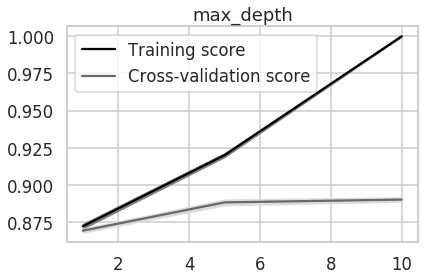

(array([[0.87, 0.87, 0.87],
        [0.92, 0.92, 0.92],
        [1.  , 1.  , 1.  ]]), array([[0.87, 0.87, 0.87],
        [0.89, 0.89, 0.89],
        [0.89, 0.89, 0.89]]))

In [14]:
#validation curves
param_name = 'max_depth'
param_range=np.linspace(1, 10, 3,dtype=int)
classifier=xgb.XGBClassifier(n_jobs=NWORKERS)
title=param_name

meu.validationCurve(classifier,train_features,train_sentiments,param_name,param_range,1,title)




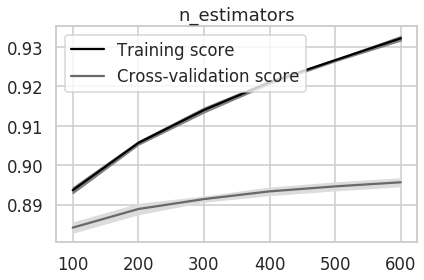

(array([[0.89, 0.89, 0.89],
        [0.91, 0.91, 0.91],
        [0.91, 0.91, 0.91],
        [0.92, 0.92, 0.92],
        [0.93, 0.93, 0.93],
        [0.93, 0.93, 0.93]]), array([[0.88, 0.89, 0.88],
        [0.89, 0.89, 0.89],
        [0.89, 0.89, 0.89],
        [0.89, 0.89, 0.89],
        [0.89, 0.9 , 0.89],
        [0.89, 0.9 , 0.9 ]]))

In [38]:
#validation curves
param_name = 'n_estimators'
param_range=[100,200,300,400,500,600]
classifier=xgb.XGBClassifier(n_jobs=NWORKERS)
title=param_name

meu.validationCurve(classifier,train_features,train_sentiments,param_name,param_range,1,title)



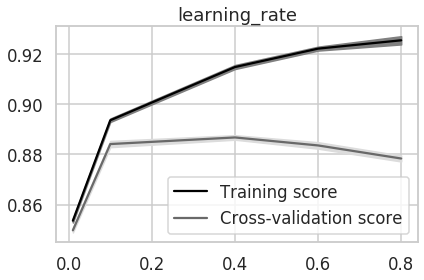

(array([[0.85, 0.85, 0.85],
        [0.89, 0.89, 0.89],
        [0.92, 0.91, 0.92],
        [0.92, 0.92, 0.92],
        [0.93, 0.92, 0.93]]), array([[0.85, 0.85, 0.85],
        [0.88, 0.89, 0.88],
        [0.89, 0.89, 0.89],
        [0.88, 0.88, 0.88],
        [0.88, 0.88, 0.88]]))

In [39]:
#validation curves
param_name = 'learning_rate'
param_range=[0.01, 0.1,0.4,0.6,0.8]
classifier=xgb.XGBClassifier(n_jobs=NWORKERS)
title=param_name

meu.validationCurve(classifier,train_features,train_sentiments,param_name,param_range,1,title)




In [40]:
try:
    xg=utils.readFromDisk('xg')
except FileNotFoundError as te:
#    xg = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,objective='binary:logistic', 
#                       random_state=42,nthread=16,n_jobs=NWORKERS)
    xg0 = xgb.XGBClassifier()

    xg_hyperparameters = {
        'max_depth': [5],
        'n_estimators': [100],
        'learning_rate': [0.1],
        'objective': ['binary:logistic'],
        'random_state': [42],
        'n_jobs': [NWORKERS]
    }

    xg_clf = GridSearchCV(xg0, xg_hyperparameters,cv=5, n_jobs=1)
    
    xg=xg_clf.fit(train_features, train_sentiments)

    utils.writeToDisk(xg,'xg')


In [44]:
    xg.best_estimator_.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 500,
 'n_jobs': 16,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [41]:
xg_predictions= xg.predict(test_features)


## XGBoost - Performance


Model Performance metrics:
------------------------------
Accuracy: 0.8914
Precision: 0.8913
Recall: 0.8914
F1 Score: 0.8913

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.87      0.86      0.87     12135
           0       0.90      0.91      0.91     16998

    accuracy                           0.89     29133
   macro avg       0.89      0.89      0.89     29133
weighted avg       0.89      0.89      0.89     29133


Prediction Confusion Matrix:
------------------------------


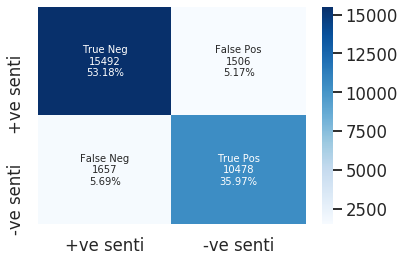

In [42]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=xg_predictions, 
                                      classes=[1,0])  


## XGBoost - Learning Curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

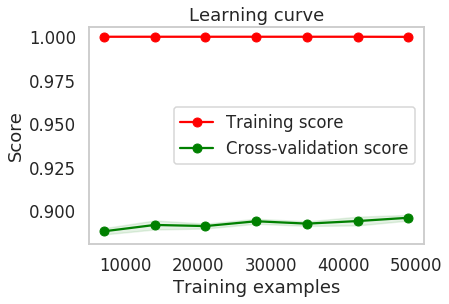

In [43]:
meu.learningCurve(train_features,train_sentiments,xg.best_estimator_,5,np.linspace(.1, 0.7, 7))



# Deep neural network architecture (DNN) (hyperparameter tuning and caching)


In [45]:
def create_dnn_model(optimizer='adam', init='glorot_uniform'):    
    dnn_model = Sequential()
    dnn_model.add(Dense(512, activation='relu', input_shape=(512,)))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(512, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(512, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax'))

    dnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer,                 
                      metrics=['accuracy'])
    return dnn_model


## DNN - Training and Prediction


In [46]:

try:   
    dnn=utils.readFromDisk('dnn')
except FileNotFoundError as te:
    #see https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/
    dnn0 = KerasClassifier(build_fn = create_dnn_model)

    # grid search epochs, batch size and optimizer
    #dnn_optimizers = ['rmsprop', 'adam']
    #dnn_init = ['glorot_uniform', 'normal', 'uniform']
    dnn_epochs = [5]
    dnn_batch_size=[512]
    dnn_validation_split=[0.1]
    dnn_shuffle=[True]
    #was crashing
    dnn_workers=[round(NWORKERS/2)]
    dnn_use_multiprocessing=[True]
    dnn_verbose=[0]
    dnn_hyperparameters = dict(epochs=dnn_epochs, 
                               batch_size=dnn_batch_size,validation_split=dnn_validation_split,
                               shuffle=dnn_shuffle, workers=dnn_workers, use_multiprocessing=dnn_use_multiprocessing,
                               verbose=dnn_verbose)
    
    
    dnn_clf = GridSearchCV(dnn0, dnn_hyperparameters,cv=5, n_jobs=1)
   
    dnn=dnn_clf.fit(train_features,train_sentiments_encoded)    
    
    utils.writeToDisk(dnn,'dnn')


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_1_input to have shape (300,) but got array with shape (512,)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_5_input to have shape (300,) but got array with shape (512,)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_9_input to have shape (300,) but go

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_97_input to have shape (300,) but got array with shape (512,)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_101_input to have shape (300,) but got array with shape (512,)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_105_input to have shape (300,) b

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_193_input to have shape (300,) but got array with shape (512,)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_197_input to have shape (300,) but got array with shape (512,)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking input: expected dense_201_input to have shape (300,) 

ValueError: Error when checking input: expected dense_241_input to have shape (300,) but got array with shape (512,)

In [ ]:
    dnn.best_estimator_.get_params()


In [ ]:
y_pred = dnn.predict(test_features)
dnn_predictions = le.inverse_transform(y_pred) 

## DNN - Performance

In [ ]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=dnn_predictions, 
                                      classes=[1,0])  


## DNN - Learning Curve

In [ ]:
meu.learningCurve(train_features,train_sentiments_encoded,dnn.best_estimator_,5,np.linspace(.1, 0.7, 7))




# LSTM


In [ ]:

# build word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

## LSTM- Encode and Pad datasets & Encode prediction class labels

In [ ]:
# get max length of train corpus and initialize label encoder
max_len = np.max([len(review) for review in tokenized_train])

## Train reviews data corpus
# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 

## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)


In [ ]:
EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

def create_lstm_model(optimizer='adam', init='glorot_uniform'):    
    lstm = Sequential()

    lstm.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
    lstm.add(SpatialDropout1D(0.2))
    lstm.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
    lstm.add(Dense(2, activation="sigmoid"))
    
    lstm.compile(loss="binary_crossentropy", optimizer="adam",
                 metrics=["accuracy"])
    #lstm.compile(loss='mse')
    return lstm




## LSTM- Build, train and visualize the LSTM Model

In [ ]:
try:   
    lstm=utils.readFromDisk('lstm')
    lstm_history=utils.readFromDisk('lstm_history')
except FileNotFoundError as te:    
    
    #see https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/
    lstm = KerasClassifier(build_fn = create_lstm_model)
    lstm_history=lstm.fit(train_X, train_sentiments_encoded,batch_size = 100, epochs = 2, verbose=1, validation_split=0.2, 
                     shuffle=True,workers=NWORKERS,use_multiprocessing=True)    

    utils.writeToDisk(lstm,'lstm')
    utils.writeToDisk(lstm_history,'lstm_history')
    

## LSTM - Predictions

In [ ]:
lstm_pred_test = lstm.predict(test_X)

In [ ]:
lstm_predictions = le.inverse_transform(lstm_pred_test)

## LSTM - Performance

In [ ]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lstm_predictions, 
                                      classes=[1,0])  



## LSTM - Learning Curve

In [ ]:
#meu.learningCurve(train_X,train_sentiments_encoded,lstm,5,np.linspace(.1, 0.7, 7))

In [ ]:
# plot train and validation loss
#plt.plot(lstm_history.history['loss'])
#plt.plot(lstm_history.history['val_loss'])
#plt.title('model train vs validation loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper right')
#plt.show()


# Ensemble Majority Vote


In [ ]:
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out


In [ ]:
maj_clf1 = LogisticRegression(penalty='l2', C=0.1, max_iter=500, random_state=0,n_jobs=3)
maj_clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
maj_clf3 = KNeighborsClassifier(n_neighbors=1,p=2, metric='minkowski',n_jobs=3)
maj_pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', maj_clf1]])
maj_pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', maj_clf3]])
maj_clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN','Majority Voting']
mclf = MajorityVoteClassifier(classifiers=[maj_pipe1, maj_clf2, maj_pipe3])
maj_clf_list = [maj_pipe1, maj_clf2, maj_pipe3, mclf]


try:
    maj_clf_list=utils.readFromDisk('maj_clf_list')
except FileNotFoundError as te:   
    maj_clf_list = [maj_pipe1, maj_clf2, maj_pipe3, mclf]
    for maj_clf in maj_clf_list:
        maj_clf=maj_clf.fit(train_features,train_sentiments_encoded)
    
    utils.writeToDisk(maj_clf_list,'maj_clf_list')

In [ ]:
try:
    maj_lr_predictions=utils.readFromDisk('maj_lr_predictions')
except FileNotFoundError as te:    
    maj_lr_predictions=maj_clf1.predict(test_features)
    utils.writeToDisk(maj_lr_predictions,'maj_lr_predictions')
try:
    maj_dt_predictions=utils.readFromDisk('maj_dt_predictions')
except FileNotFoundError as te:    
    maj_dt_predictions=maj_clf2.predict(test_features)
    utils.writeToDisk(maj_dt_predictions,'maj_dt_predictions')

try:
    maj_knn_predictions=utils.readFromDisk('maj_knn_predictions')
except FileNotFoundError as te:    
    maj_knn_predictions=maj_clf3.predict(test_features)
    utils.writeToDisk(maj_knn_predictions,'maj_knn_predictions')


try:
    maj_predictions=utils.readFromDisk('maj_predictions')
except FileNotFoundError as te:    
    maj_predictions=mclf.predict(test_features)
    utils.writeToDisk(maj_predictions,'maj_predictions')
    

## Ensemble Majority Voting Performance

In [ ]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=maj_lr_predictions,
                                      classes=[1,0])  

In [ ]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=maj_dt_predictions, 
                                      classes=[1,0])  

In [ ]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=maj_knn_predictions, 
                                      classes=[1,0])  

In [ ]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=maj_predictions, 
                                      classes=[1,0])  



## Ensemble Majority Voting - Learning Curve


In [ ]:
meu.learningCurve(train_features,train_sentiments,mclf,5,np.linspace(.1, 0.7, 7))



# All Models Evaluation


## Model ROC curves

In [ ]:
plt.figure(0).clf()

color = ['blue', 'orange', 'red', 'green', 'coral',
             'grey', 'indigo', 'gold', 'lime', 'olive',
             'pink', 'navy', 'magenta', 'yellow', 'tomato',
             'turquoise', 'yellowgreen', 'maroon', 'lightblue']
mlr=[]
msvm=[]
mnb=[]
mrf=[]
mdnn=[]
mxg=[]
mlstm=[]
mknn=[]
mstacklr=[]
mstackdt=[]
mstackknn=[]
mstackmaj=[]


mens=[]

def metricsAndROC(pred,metricsArray,rocTitle,colorIndex):
    fpr, tpr, thresholds = metrics.roc_curve(test_sentiments, pred)
    auc = metrics.roc_auc_score(test_sentiments, pred)
    metricsArray.append(metrics.f1_score(test_sentiments, pred))
    metricsArray.append(metrics.precision_score(test_sentiments, pred))
    metricsArray.append(metrics.accuracy_score(test_sentiments, pred))
    metricsArray.append(metrics.recall_score(test_sentiments, pred))
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr,color=color[colorIndex], label=rocTitle.format(auc))


metricsAndROC(lr_predictions,mlr,'LR',0)
metricsAndROC(svm_predictions,msvm,'SVM',1)
metricsAndROC(nb_predictions,mnb,'GAU',2)
metricsAndROC(rf_predictions,mrf,'RF',3)
metricsAndROC(dnn_predictions,mdnn,'DNN',4)
metricsAndROC(xg_predictions,mxg,'XGBoost',5)
metricsAndROC(lstm_predictions,mlstm,'LSTM',6)
metricsAndROC(maj_lr_predictions,mstacklr,'ENSEM-LR',7)
metricsAndROC(maj_dt_predictions,mstackdt,'ENSEM-DT',8)
metricsAndROC(maj_knn_predictions,mstackknn,'ENSEM-KNN',9)
metricsAndROC(maj_predictions,mstackmaj,'ENSEM-MAJ',10)



#show the roc curve now
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# show the legend
plt.legend(loc='center right')
plt.show()

## All Models Metrics comparison

In [ ]:
n_groups = 4
index = np.arange(n_groups)
bar_width = .1

plt.bar(index,mlr, bar_width, color=color[0], label='LR')


z=index + bar_width
plt.bar(z, msvm, bar_width, color=color[1],label='SVM')


z=index + bar_width
plt.bar(z, mnb, bar_width, color=color[2],label='GAU')

z=index + bar_width
plt.bar(z, mrf, bar_width, color=color[3],label='RF')

z=z+ bar_width
plt.bar(z, mdnn, bar_width, color=color[4], label='DNN')

z=z+ bar_width
plt.bar(z,mxg , bar_width, color=color[5], label='XGB')

z=z+ bar_width
plt.bar(z,mlstm , bar_width,color=color[6], label='LSTM')

z=z+ bar_width
plt.bar(z,mlstm , bar_width,color=color[7], label='LSTM')

z=z+ bar_width
plt.bar(z,mstackmaj , bar_width,color=color[8], label='ENS')

#ax.set_xlabel('Metric')
#ax.set_ylabel('Value')
#ax.set_title('Comparison of Feature Engineering Models on Amazon Reviews')
#ax.set_xticks(index + bar_width / 2)
pltLabels=['F1','PRECISION','ACCURACY','RECALL']
# Add xticks on the middle of the group bars
plt.xlabel('Model Metrics', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_groups)], pltLabels)
 
# Create legend & Show graphic
plt.legend(frameon=False,ncol=3, loc='lower left')
plt.show()
